# Classificação de redes neurais

<ul>
    <li>Classificação binária</li>
    <li>Classificação multiclasses</li>
    <li>Classificação multirrótulo: o feature pode receber mais de um target</li>
</ul>

Muitos problemas não são resolvidos apenas com regressão linear, então fazemos outros tipos de soluções

In [1]:
from sklearn.datasets import make_circles

n_amostras = 1000

# Create circles
X, y = make_circles(n_amostras,
                    noise=0.03, # um pouco de ruído nos pontos
                    random_state=42) # manter o estado aleatório para que obtenhamos os mesmos valores

print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


Essa saida nos mostra 2 coisas: X é a representação de uma coordenada, Y é a saida, e existem 2 tipos de saida, 0 e 1 

In [2]:
# Vamos fazer uma visualização mais geral dos dados

import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

display(circles.head(10))

# Quantos existem de cada classe?
display(circles.label.value_counts())

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


label
1    500
0    500
Name: count, dtype: int64

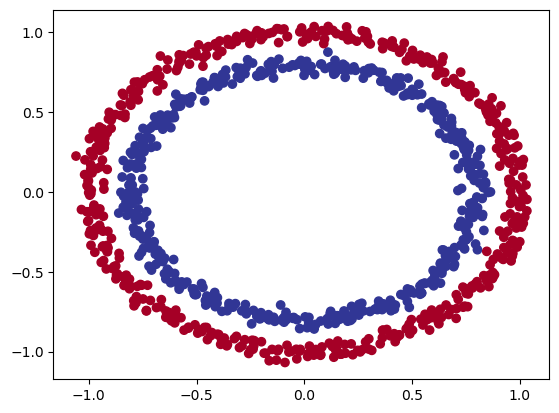

In [3]:
# Visualize with a plot
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

# Input and output shapes

É um dos tipos mais comuns de erros

Para tentar evitar esse tipo de erro: "Quais são os shapes das minhas entradas e quais são os shapes das minhas saídas?"

In [4]:
print(X.shape, y.shape)
# Aqui vemos que X tem um vetor de entrada e y é um escalar de saida

(1000, 2) (1000,)


# Transformando os dados em tensores e criando divisões de treino e teste

No momento, nossos dados estão em arrays NumPy, mas o PyTorch prefere trabalhar com tensores PyTorch.

In [5]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [6]:
# Dividindo treino e teste
# Vamos construir um modelo que prevê se o ponto está no ciclo interno ou externo dos circulos

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Construindo um modelo

<ol>
    <li>Configurar o ambiente de trabalho(device)</li>
    <li>Construir um modelo de subclasses(nn.Model)</li>
    <li>Definir a loos_function</li>
    <li>Criar o loop de treinamento</li>
</ol>

# Configurar o ambiente de trabalho(device)

In [7]:
def select_workspace():
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"

    return device

device = select_workspace()
print(device)

cpu


# Construir um modelo de subclasses(nn.Model)

In [8]:
from torch import nn

# Queremos um modelo capaz de:
    # Receber os dados de X como entrada
    # Produzir algo com a mesma forma de y como saída

# Para isso, precisamos lidar com os shapes de entradas e saidas

class CirculoModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5) # recebe 2 features (X), produz 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # recebe 5 features, produz 1 feature (y)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
modelo = CirculoModel()

self.layer_1 recebe 2 features de entrada (in_features=2) e produz 5 features de saída (out_features=5). Isso é conhecido como ter 5 unidades ocultas ou neurônios.

Essa camada transforma os dados de entrada, que tinham 2 features, em 5 features. Por que fazer isso? Isso permite que o modelo aprenda padrões a partir de 5 números em vez de apenas 2, potencialmente levando a melhores resultados.

A única regra sobre unidades ocultas é que a próxima camada, no nosso caso self.layer_2, precisa ter in_features igual ao out_features da camada anterior.

Agora, faremos uma analise dos shapes

In [9]:
# Fazer previsões com o modelo
untrained_preds = modelo(X_test.to(device))
print(f"Comprimento das previsões: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Comprimento das amostras de teste: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nPrimeiras 10 previsões:\n{untrained_preds[:10]}")
print(f"\nPrimeiros 10 rótulos de teste:\n{y_test[:10]}")


Comprimento das previsões: 200, Shape: torch.Size([200, 1])
Comprimento das amostras de teste: 200, Shape: torch.Size([200])

Primeiras 10 previsões:
tensor([[0.2262],
        [0.2195],
        [0.3990],
        [0.1766],
        [0.6455],
        [0.6395],
        [0.4253],
        [0.5243],
        [0.3883],
        [0.2218]], grad_fn=<SliceBackward0>)

Primeiros 10 rótulos de teste:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Aqui temos um problema com os shapes, pois:
- Previsões.shape = [200, 1]
- Rotulos.shape   = [200]

Eles têm a mesma quantidade de elementos, mas não têm exatamente o mesmo formato.

Temos alguns passos que podemos fazer para corrigir isso, e vamos ver eles mais adiante.

# Definir a loos_function e optimizer

Já configuramos uma função de perda (também chamada de critério ou cost function) e um otimizador antes no notebook 01.

Mas diferentes tipos de problema exigem funções de perda diferentes.

Por exemplo, para um problema de regressão (prever um número), você poderia usar mean absolute error (MAE).

Para um problema de classificação binária (como o nosso), geralmente se usa binary cross entropy como função de perda.

O mesmo otimizador, no entanto, pode ser usado em diferentes tipos de problemas:

Stochastic Gradient Descent (SGD) → classificação, regressão, muitos outros.

Adam → classificação, regressão, muitos outros.

<table>
    <tr>
        <th>Função loss/optim</th>
        <th>Problema que Resolve</th>
        <th>Pytorch code</th>
    </tr>
    <tr>
        <td>Stochastic Gradient Descent (SGD) optimizer</td>
        <td>Classification, regression, many others.</td>
        <td>torch.optim.SGD()</td>
    </tr>
    <tr>
        <td>Adam Optimizer</td>
        <td>Classification, regression, many others.</td>
        <td>torch.optim.Adam()</td>
    </tr>
    <tr>
        <td>Binary cross entropy loss</td>
        <td>Binary classification</td>
        <td>torch.nn.BCEWithLogitsLoss()</td>
    </tr>
    <tr>
        <td>Cross entropy loss</td>
        <td>Multi-class classification</td>
        <td>torch.nn.CrossEntropyLoss</td>
    </tr>
    <tr>
        <td>Mean absolute error (MAE) or L1 Loss</td>
        <td>Regression</td>
        <td>torch.nn.L1Loss</td>
    </tr>
    <tr>
        <td>Mean squared error (MSE) or L2 Loss</td>
        <td>Regression</td>
        <td>torch.nn.MSELoss</td>
    </tr>
</table>


In [14]:
# Como estamos trabalhando com classificação binária, vamos usar binary cross entropy.

loss_fn = nn.BCEWithLogitsLoss()
optmizer = torch.optim.SGD(params=modelo.parameters(), lr=0.1)


Também vamos criar uma métrica de avaliação.

Função de perda mede o quão errado o modelo está.

Métrica de avaliação mede o quão certo ele está.

In [11]:
# Calcula acurácia
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()  # verifica onde os tensores são iguais
    acc = (correct / len(y_pred)) * 100
    return acc

# Treinando o modelo

In [18]:
y_logits = modelo(X_test.to(device))[:5]
y_logits

tensor([[0.2262],
        [0.2195],
        [0.3990],
        [0.1766],
        [0.6455]], grad_fn=<SliceBackward0>)

In [ ]:
# Usar sigmoid nos logits do modelo
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs # dads transformados em formato de probabilidades de previsão

# ou seja, os valores representam a confiança do modelo de que um ponto de dados pertence a uma classe ou outra.
# No nosso caso, como é classificação binária, os outputs ideais seriam 0 ou 1.

# Mais especificamente:
# Se y_pred_probs >= 0.5 → y = 1 (classe 1)
# Se y_pred_probs < 0.5 → y = 0 (classe 0)

tensor([[0.5563],
        [0.5547],
        [0.5984],
        [0.5440],
        [0.6560]], grad_fn=<SigmoidBackward0>)

In [25]:

# Variáveis

# selecionando hardware
device = select_workspace()

modelo = modelo.to(device)
X_train = X_train.to(device)
X_test  = X_test.to(device)
y_train = y_train.to(device).squeeze()
y_test  = y_test.to(device).squeeze()

# criando listas vazias para comparar os resultados
train_loss_values = []
test_loss_values = []
epoch_count = []

# Epocas
EPOCAS = 1000


In [28]:
# Loop de treino

for epoca in range(1, EPOCAS + 1):
    modelo.train()

    y_pred = modelo(X_train)
    y_pred = y_pred.squeeze()
    y_pred = torch.sigmoid(y_pred)

    loss = loss_fn(y_pred, y_train)
    
    optmizer.zero_grad()

    loss.backward()

    optmizer.step()

    modelo.eval()

    with torch.inference_mode():
        # 1. Passa por cada elemento do teste
        test_pred = modelo(X_test).squeeze()

        # 2. calcula perda
        test_loss = loss_fn(test_pred, y_test.type(torch.float))
        # previsões vêm no tipo de dados torch.float, portanto, as comparações precisam ser feitas com tensores do mesmo tipo
        
        # printa oq esta acontecendo
        epoch_count.append(epoca)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        
        if epoca % 1 == 0:
            print(f"epoca: {epoca} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

epoca: 1 | MAE Train Loss: 0.6941367387771606 | MAE Test Loss: 1.254075288772583 
epoca: 2 | MAE Train Loss: 0.6941351294517517 | MAE Test Loss: 1.2544176578521729 
epoca: 3 | MAE Train Loss: 0.6941336989402771 | MAE Test Loss: 1.254759669303894 
epoca: 4 | MAE Train Loss: 0.6941320896148682 | MAE Test Loss: 1.2551014423370361 
epoca: 5 | MAE Train Loss: 0.694130539894104 | MAE Test Loss: 1.2554428577423096 
epoca: 6 | MAE Train Loss: 0.6941291093826294 | MAE Test Loss: 1.2557839155197144 
epoca: 7 | MAE Train Loss: 0.6941275596618652 | MAE Test Loss: 1.2561246156692505 
epoca: 8 | MAE Train Loss: 0.6941260695457458 | MAE Test Loss: 1.2564650774002075 
epoca: 9 | MAE Train Loss: 0.6941245198249817 | MAE Test Loss: 1.2568050622940063 
epoca: 10 | MAE Train Loss: 0.6941230893135071 | MAE Test Loss: 1.257144570350647 
epoca: 11 | MAE Train Loss: 0.6941215395927429 | MAE Test Loss: 1.257483959197998 
epoca: 12 | MAE Train Loss: 0.6941200494766235 | MAE Test Loss: 1.2578229904174805 
epoca: